In [19]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error



In [20]:

df = pd.read_csv('county_wind_data_daily.csv')
df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [21]:
df.head(4)

,Turkana,Marsabit,Mandera,Wajir,West Pokot,Samburu,Isiolo,Baringo,Keiyo-Marakwet,Trans Nzoia,...,Machakos,Kajiado,Nairobi,Makueni,Lamu,Kilifi,Taita Taveta,Kwale,Mombasa,Offshore
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2.996525,3.895012,6.091564,4.776902,2.415018,3.667870,3.893077,2.489949,2.062520,1.969233,...,2.542188,1.865523,2.512468,2.384761,4.035438,3.453557,2.826592,3.825063,5.101016,4.711883
2013-01-02,2.927869,3.564266,7.460170,5.276932,2.230166,3.400834,3.494111,2.302518,1.784904,2.447548,...,3.133444,2.275361,2.770381,2.745374,6.123332,4.609838,3.156645,4.596151,6.598992,6.300280
2013-01-03,4.216523,5.070172,8.072244,6.634514,3.019275,4.080532,3.441163,2.744170,2.427173,3.107861,...,3.839431,3.426823,3.783524,3.636042,7.392458,5.337059,4.128239,4.774348,6.615375,7.425250
2013-01-04,4.481573,5.411084,6.546825,5.551257,3.034143,4.091824,3.210454,2.502717,1.979747,1.646491,...,3.302754,2.691994,3.697211,3.165507,6.614271,4.938317,3.771317,4.603389,6.474643,6.572825


### TIME SERIES FORECASTING USING XGBOOST

In [22]:
def create_model_and_combine_df(df, county_name, start_date='2023-12-01', prediction_duration=365, lag_steps=3, test_size=0.2):
    # Create lag features for the specific county
    df_county = df[[county_name]].copy()

    # Create lag features for the entire DataFrame
    for i in range(1, lag_steps + 1):
        df_county[f'lag_{i}'] = df_county[county_name].shift(i)

    # Drop rows with NaN values introduced by lag features
    df_county = df_county.dropna()

    # Split the data into training and testing sets
    train_size = int(len(df_county) * (1 - test_size))
    train_data, test_data = df_county.iloc[:train_size], df_county.iloc[train_size:]

    # Define target variable and features
    y_train = train_data[county_name]
    X_train = train_data.drop(columns=[county_name])
    y_test = test_data[county_name]
    X_test = test_data.drop(columns=[county_name])

    # Initialize XGBoost model
    model = XGBRegressor()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions for the next year
    future_dates = pd.date_range(start=start_date, periods=prediction_duration, freq='D')
    all_predictions = model.predict(df_county.drop(columns=[county_name]))

    # Create a DataFrame with dates and predictions
    predictions_df = pd.DataFrame({'time': future_dates, 'Predicted_Wind_Speed': all_predictions[:prediction_duration]})

    # Set 'time' as the index for predictions_df
    predictions_df.set_index('time', inplace=True)

    # Combine the DataFrames
    combined_df = pd.concat([df_county, predictions_df], axis=0)

    # Return predictions, model, and combined DataFrame
    return all_predictions, model, combined_df


In [23]:
def plot_combined_data(combined_df, county_name):
    # Plotting the combined data
    plt.figure(figsize=(10, 6))
    plt.plot(combined_df.index, combined_df[county_name], label='Historical Wind Speed', color='blue')
    plt.plot(combined_df.index, combined_df['Predicted_Wind_Speed'], label='Predicted Wind Speed', color='red')

    # Setting labels and title
    plt.title(f'Combined Historical and Predicted Wind Speed for {county_name}')
    plt.xlabel('Date')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.grid(True)
    plt.show()

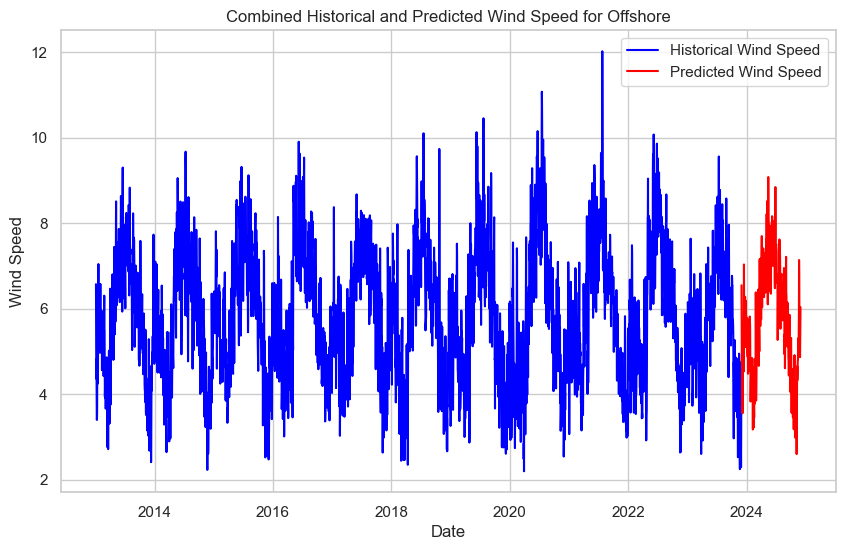

In [24]:
# Example usage:
county_to_forecast = 'Offshore'
Offshore_model, Offshore_predictions, Offshore_combined_df = create_model_and_combine_df(df, county_to_forecast, prediction_duration=365)
plot_combined_data(Offshore_combined_df, 'Offshore')


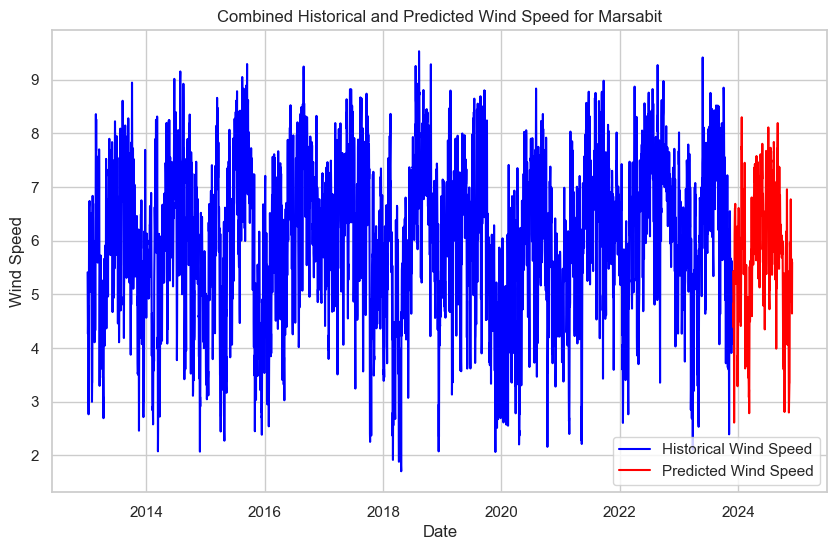

In [25]:
# Example usage:
county_to_forecast = 'Marsabit'
Marsabit_model, Marsabit_predictions, Marsabit_combined_df = create_model_and_combine_df(df, county_to_forecast, prediction_duration=365)
plot_combined_data(Marsabit_combined_df, 'Marsabit')

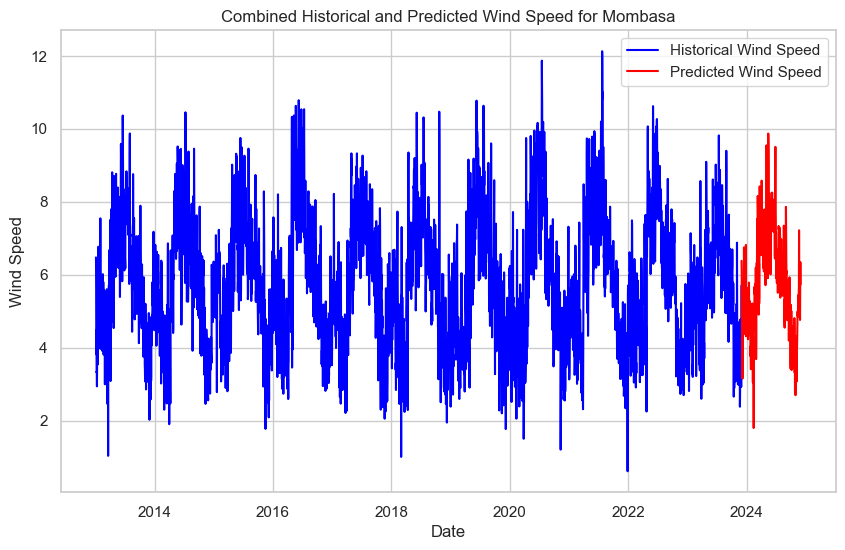

In [26]:
county_to_forecast = 'Mombasa'
Mombasa_model, Mombasa_predictions, Mombasa_combined_df = create_model_and_combine_df(df, county_to_forecast, prediction_duration=365)
plot_combined_data(Mombasa_combined_df, 'Mombasa')